# Lista 4 - Lista 3 - Processamento Adaptativos de Sinais - COE718
## Alexandre Henrique da Silva Nunes

In [1]:
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
sys.path.append('../../LMS-based-algorithms')

from sign_error import *
from complex_lms import *
from scipy import signal

In [2]:
class LMS:
    """
    Description
    ---------
    
    Implements the Complex LMS algorithm for COMPLEX valued data.
    (Algorithm 3.2 - book: Adaptive Filtering: Algorithms and Practical Implementation, Diniz)
    
    Author: Alexandre Henrique da Silva Nunes
    Based on Matlab code by Markus Vinícius Santos Lima available at 
    https://www.mathworks.com/matlabcentral/fileexchange/3582-adaptive-filtering
    
    Methods
    ---------
    fit :
        update filter params based on a desired signal and inputs.
    """
    
    def __init__(self, filter_order_num, initial_coefficients):
        """
        Inputs
        -------
        
        filter_order_num : int
                    Order of the FIR filter
        initial_coefficients : numpy array (collumn vector)
                    initial filter coefficients
                
                    
        Variables
        --------
        num_of_coefficients : int
            FIR filter number of coefficients.
        
        errors_vector : numpy array
            FIR error vectors. error_vector[k] represents the output erros at iteration k.
        outputs_vector : numpy array (collumn vector)
            Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
        coefficients_mtx : numpy array
            Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)
        """
        
        self.filter_order_num = filter_order_num
        self.num_of_coefficients = self.filter_order_num + 1
        
        self.errors_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.outputs_vector = np.array([0], dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.array(initial_coefficients, dtype=initial_coefficients.dtype)
        
    def fit(self, desired, x, step):
        """
        Fit filter parameters to considering desired vector and input x. desired and x must have length K,
        where K is the number of iterations
        
        Inputs
        -------
        
        desired : numpy array (row vector)
            desired signal
        x : numpy array (row vector)
            input signal to feed filter
        step : Convergence (relaxation) factor.
        
        Outputs
        -------
        
        python dic :
            outputs : numpy array (collumn vector)
                Store the estimated output of each iteration. outputs_vector[k] represents the output erros at iteration k
            errors : numpy array (collumn vector)
                FIR error vectors. error_vector[k] represents the output erros at iteration k.
            coefficients_mtx : numpy array
                Store the estimated coefficients for each iteration. (Coefficients at one iteration are COLUMN vector)      
        """
        
        k_max = self._dim(desired)
        self._initialize_vars(k_max)
        
        for k in range(k_max):
            x_k = LMS.tapped_x(x, self.num_of_coefficients, k)
            w_k = self.coefficients_mtx[:, k]
            y_k = np.dot(LMS._conj(w_k), x_k)
            err_k = desired[k] - y_k
        
            next_w_k = w_k + step * LMS._conj(err_k) * x_k
            
            self._update(err_k, y_k, next_w_k, k)
            
        return {
            'outputs': self.outputs_vector,
            'errors': self.errors_vector,
            'coefficients': self.coefficients_mtx
        }
        
    def _initialize_vars(self, k_max):
        self.errors_vector = np.zeros((k_max, 1))
        self.outputs_vector = np.zeros((k_max, 1), dtype=self.outputs_vector.dtype)
        
        initial_coefficients = self.coefficients_mtx[:, [0]]
        last_coefficients = np.zeros((self.num_of_coefficients, k_max), dtype=initial_coefficients.dtype)
        self.coefficients_mtx = np.append(initial_coefficients, last_coefficients, axis=1)
    
    def _update(self, err, y, next_w, k):
        self.errors_vector[k, 0] = err
        self.outputs_vector[k, 0] = y
        self.coefficients_mtx[:, k+1] = np.transpose(next_w)
    
    @staticmethod
    def tapped_x(x, window, k):
        prefixed_input = LMS._range_x(x, k-window+1, k+1)
        return prefixed_input[::-1]
    
    @staticmethod
    def _x(x, index):
        if index < 0:
            if x.dtype == complex: return complex(0, 0)
            return 0;
        return x[index]
    
    # Improve source code regularity
    @staticmethod
    def _range_x(x, start, length):
        sub_x = [LMS._x(x, start)]
        for it in range(start+1, length):
            sub_x = np.append(sub_x, LMS._x(x, it))
        return sub_x
    
    @staticmethod
    def _dim(vec):
        return vec.shape[0]
    
    @staticmethod
    def _conj(vec):
        return np.conjugate(vec)

## Questão 4.8
### Item a

Cálculo do traço da matriz

In [3]:
sigma_nx = 0.5
sigma_n = 1e-3
N = 11

def first_order_markov_r(a1, lag, var_n):
    return ((-a1) ** abs(lag))/(1 - a1 ** 2) * var_n

def tr_R_problem_8(N):
    return first_order_markov_r(0.9, 0, sigma_nx) * (N+1)

trR = tr_R_problem_8(N)
print('Traço de R: ', trR)

Traço de R:  31.578947368421062


Cálculo do $\mu_{max}$

In [4]:
def sign_error_mu_max(trR, err):
    return math.sqrt((math.pi * err)/2)/trR

In [5]:
mu_max = sign_error_mu_max(trR, sigma_n)
print('Passo máximo: ', mu_max)

Passo máximo:  0.0012550536442419032


### Item b

Configurando o problema

In [13]:
def generate_uniform_noise(kmax, var_n):
    regular_noise = np.random.uniform(-1, 1, kmax)
    return (regular_noise - regular_noise.mean())/np.sqrt(regular_noise.var()/var_n)

def generate_gaussian_noise(kmax, var_n):
    return np.random.normal(0, np.sqrt(var_n), size=kmax)

def generate_problem_8_x(kmax):
    sigma_nx = 0.5
    nx = generate_uniform_noise(kmax, sigma_nx)
    
    hin_a = [1, -0.9]
    hin_b = [1, 0]
    return signal.lfilter(hin_b, hin_a, nx)

def generate_problem_8_d(kmax, x):
    h_a = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    h_b = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]
    
    sigma_n = 1e-3
    n = generate_gaussian_noise(kmax, sigma_n)
    
    return signal.lfilter(h_b, h_a, x) + n

def problem_8_single_ensemble(kmax, step):
    x = generate_problem_8_x(kmax)
    d = generate_problem_8_d(kmax, x)
    N = 11
    w0 = np.zeros((N+1, 1))
    
    model = SignError(N, w0)
    return model.fit(d, x, step)
    

$\mu = \mu_{max}/2$

In [18]:
kmax = 50000
step = mu_max/2

def perform_problem_8_for_ensembles(kmax, step, ensembles):
    outputs_mean = 0
    errors_mean = 0
    coefficients_mean = 0
    
    for i in range(0, ensembles):
        result = problem_8_single_ensemble(kmax, step)
        outputs_mean += result['outputs']
        errors_mean += result['errors']
        coefficients_mean += result['coefficients']
        
    return outputs_mean, errors_mean, coefficients_mean

ensembles = 25

outputs_mean, errors_mean, coefficients_mean = perform_problem_8_for_ensembles(kmax, step, ensembles)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


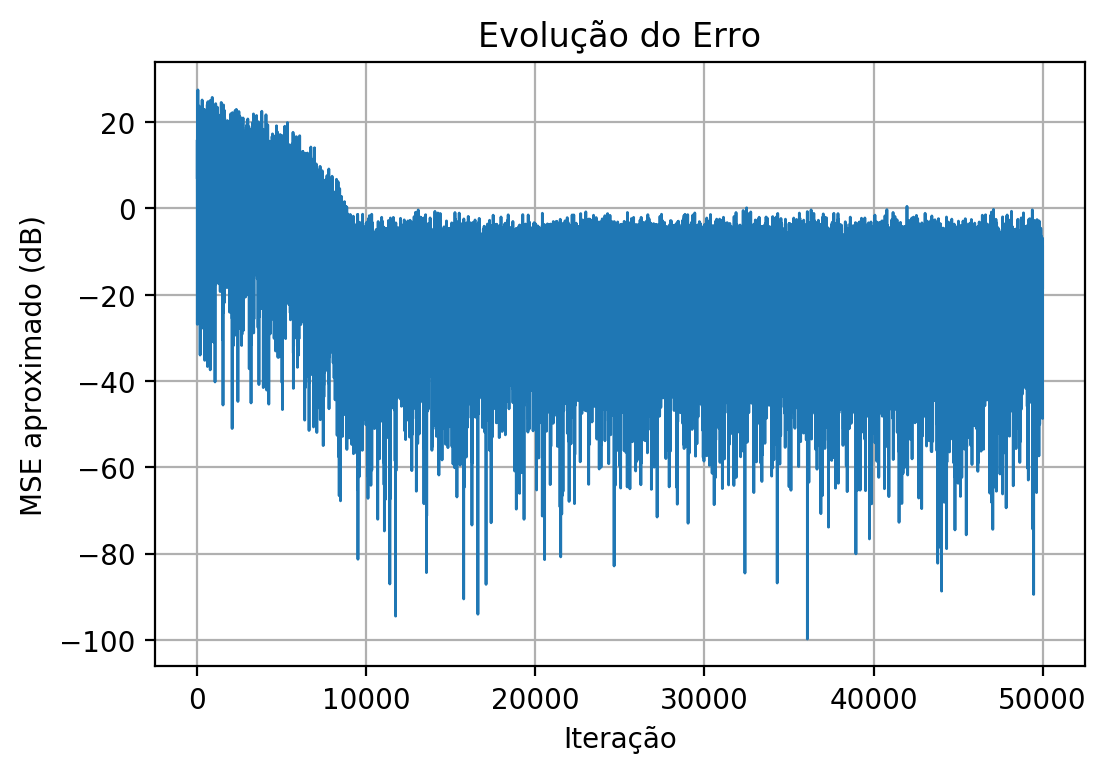

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


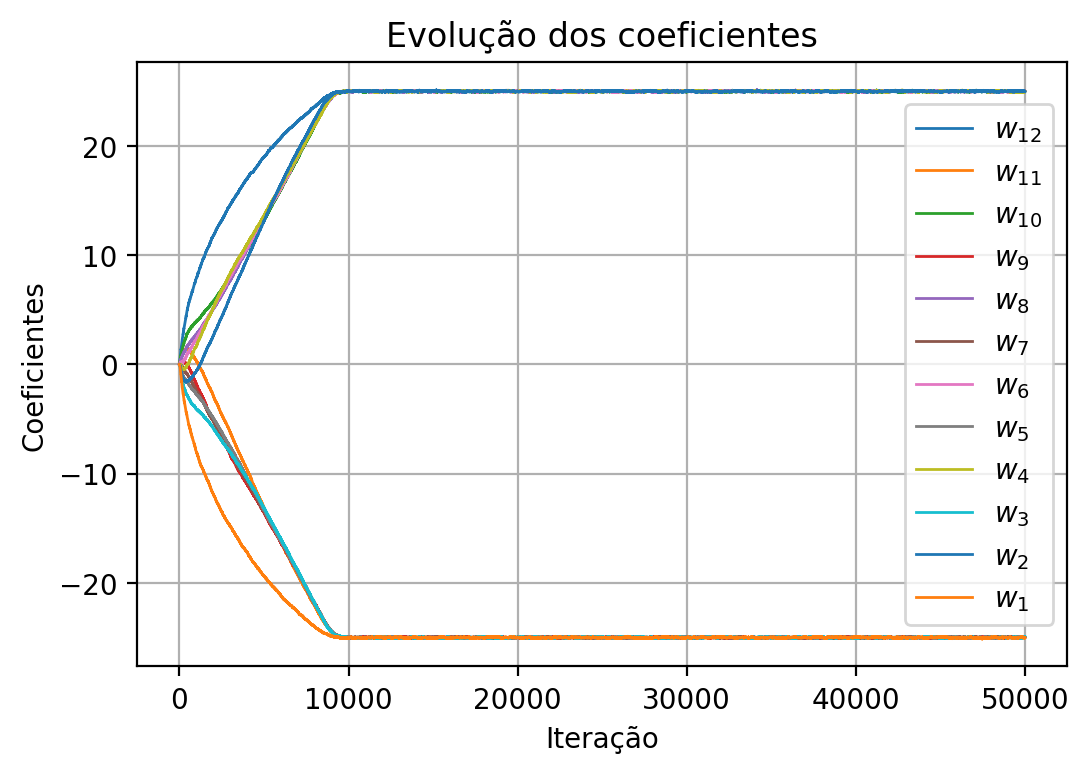

In [19]:
def plot_and_save_mse(errors, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)  
    ax.plot(np.linspace(1, kmax, kmax), 10 * np.log10(np.square(errors)), color='#1f77b4', linewidth=1)
    ax.grid(True)
    ax.set_xlabel('Iteração')
    ax.set_ylabel('MSE aproximado (dB)')
    ax.set_title('Evolução do Erro')
    fig.savefig(save_path, bbox_inches = 'tight')

def plot_and_save_coefficients(coeffs, save_path):
    fig, ax = plt.subplots(ncols=1, nrows=1, dpi=200)
    for i in range(12):
        index = 12 - i
        ax.plot(np.linspace(1, kmax+1, kmax+1), coefficients_mean[i, :], linewidth=1, label='$w_{%i}$' % index)
    ax.grid(True)
    ax.legend()
    ax.set_xlabel('Iteração')
    ax.set_ylabel('Coeficientes')
    ax.set_title('Evolução dos coeficientes')
    fig.savefig(save_path, bbox_inches = 'tight')

plot_and_save_mse(errors_mean, 'lista3_8a1.pdf')
plot_and_save_coefficients(coefficients_mean, 'lista3_8a2.pdf')

$\mu = \mu_{max}/10$

In [23]:
kmax = 50000
step = mu_max/10
ensembles = 25

outputs_mean2, errors_mean2, coefficients_mean2 = perform_problem_8_for_ensembles(kmax, step, ensembles)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


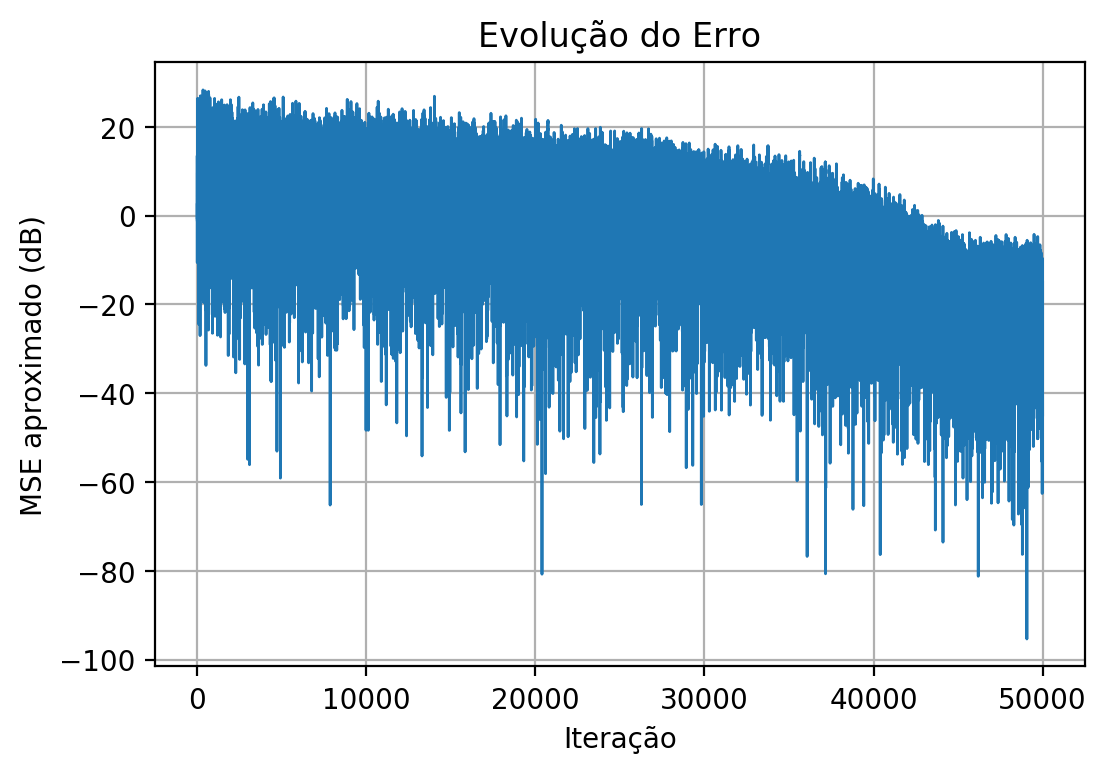

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


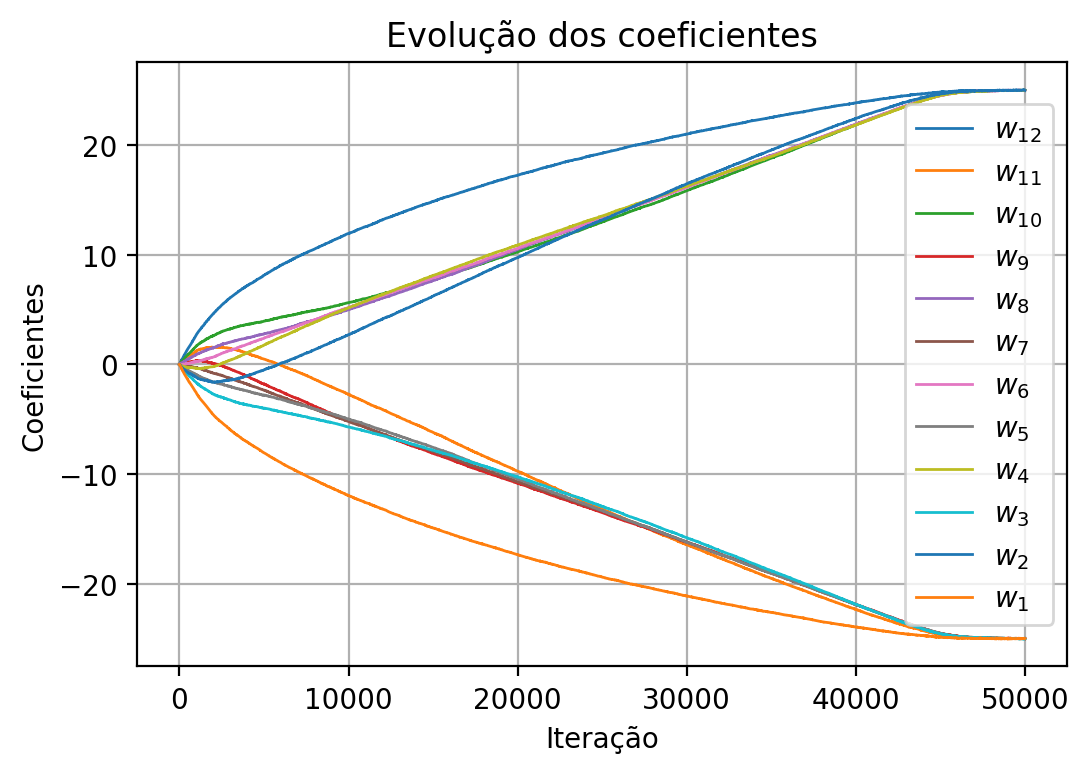

In [24]:
plot_and_save_mse(errors_mean2, 'lista3_8a3.pdf')
plot_and_save_coefficients(coefficients_mean2, 'lista3_8a4.pdf')

$\mu = \mu_{max}/50$

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


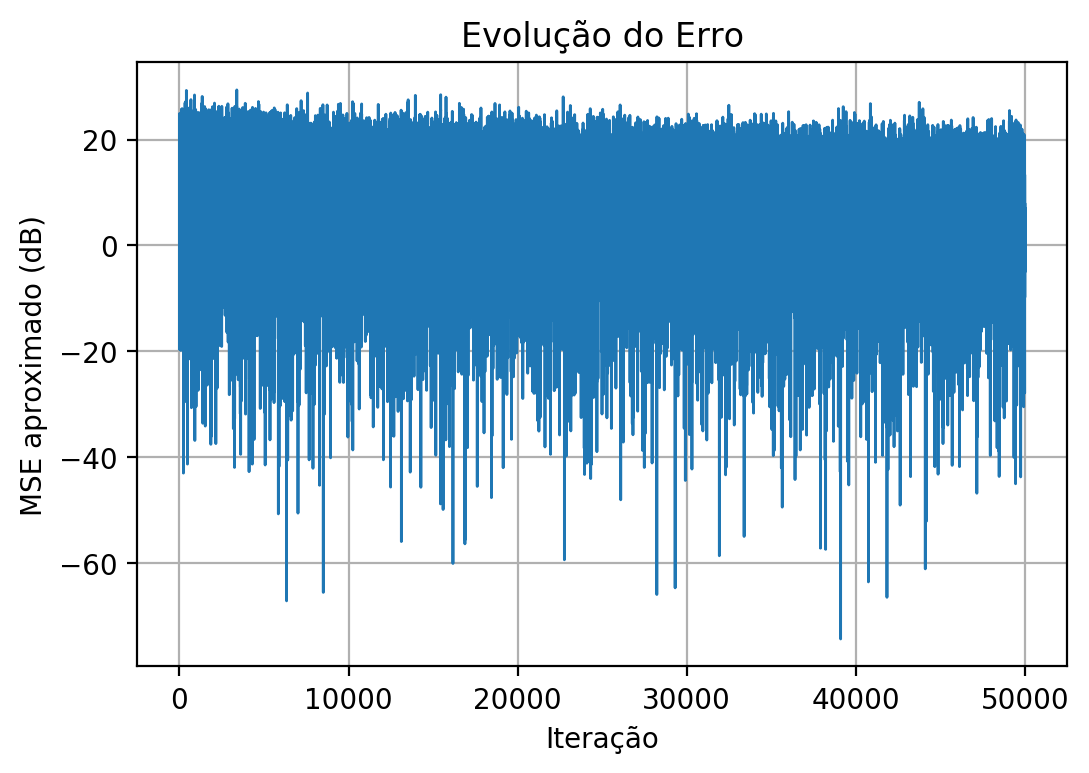

/usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


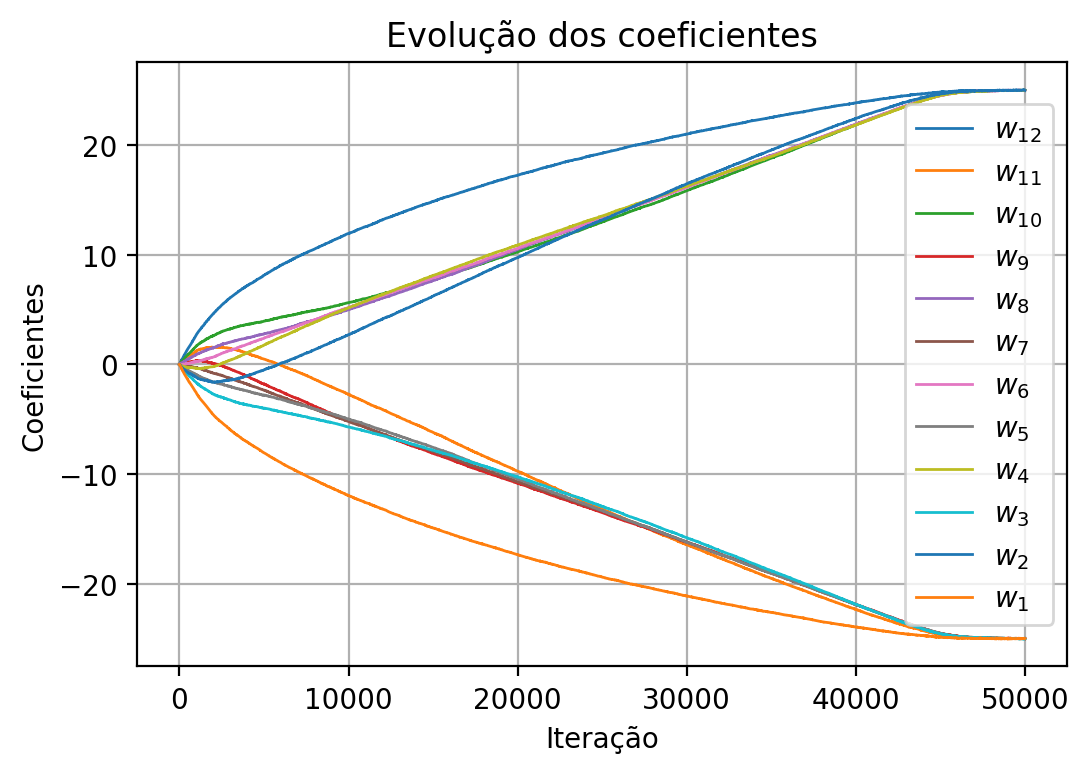

In [25]:
kmax = 50000
step = mu_max/50
ensembles = 25

outputs_mean3, errors_mean3, coefficients_mean3 = perform_problem_8_for_ensembles(kmax, step, ensembles)
plot_and_save_mse(errors_mean3, 'lista3_8a5.pdf')
plot_and_save_coefficients(coefficients_mean3, 'lista3_8a6.pdf')